In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Menentukan random seed untuk reproduksi hasil
np.random.seed(42)

print("Libraries imported!")

Libraries imported!


# Implementasi Kalman Filter untuk Estimasi Posisi Robot

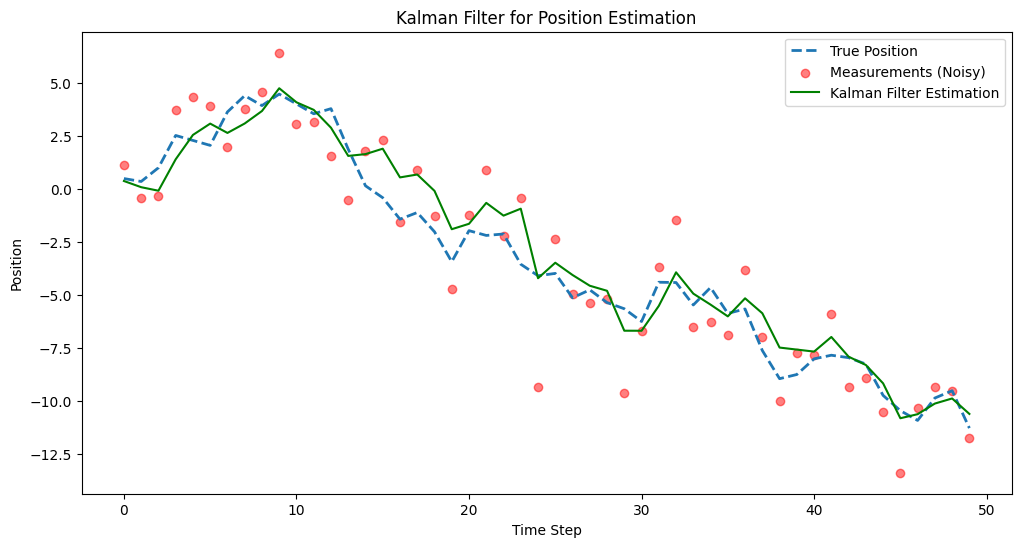

In [ ]:
# Simulasi posisi sebenarnya dari robot
num_steps = 50  # Jumlah langkah simulasi
true_position = np.cumsum(np.random.randn(num_steps))  # Pergerakan sebenarnya

# Simulasi pengukuran dengan noise
measurement_noise = 2.0
measurements = true_position + np.random.randn(num_steps) * measurement_noise

# Inisialisasi Kalman Filter
estimated_position = np.zeros(num_steps)
estimated_velocity = 0
uncertainty = 1.0

# Parameter model
process_noise = 1.0  # Noise sistem
measurement_uncertainty = measurement_noise**2
A = 1.0  # Dinamika sistem
H = 1.0  # Model pengukuran

# Algoritma Kalman Filter
for t in range(num_steps):
    # Predict step
    estimated_position[t] = estimated_position[t-1] + estimated_velocity
    uncertainty += process_noise

    # Update step
    kalman_gain = uncertainty / (uncertainty + measurement_uncertainty)
    estimated_position[t] += kalman_gain * (measurements[t] - estimated_position[t])
    uncertainty *= (1 - kalman_gain)

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(true_position, label="True Position", linestyle='--', linewidth=2)
plt.scatter(range(num_steps), measurements, color='red', alpha=0.5, label="Measurements (Noisy)")
plt.plot(estimated_position, label="Kalman Filter Estimation", color='green')
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.legend()
plt.title("Kalman Filter for Position Estimation")
plt.show()

#Implementasi Filter Partikel untuk Estimasi Posisi Robot

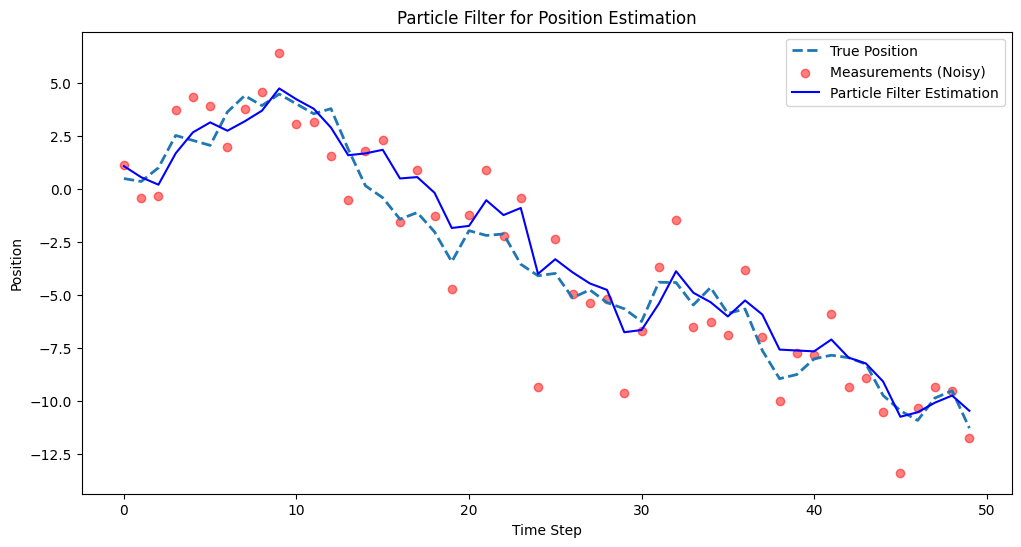

In [ ]:
# Parameter awal
num_particles = 500  # Jumlah partikel
particles = np.random.randn(num_particles) * 5  # Inisialisasi partikel secara acak
weights = np.ones(num_particles) / num_particles  # Bobot awal sama rata

# Simulasi posisi sebenarnya dan pengukuran (diambil dari Cell 2)
particle_estimations = []

for t in range(num_steps):
    # Predict step: tambahkan noise pada setiap partikel
    particles += np.random.randn(num_particles)

    # Update step: hitung bobot berdasarkan likelihood pengukuran
    weights *= np.exp(-0.5 * ((measurements[t] - particles) / measurement_noise)**2)
    weights /= np.sum(weights)  # Normalisasi bobot

    # Resampling step: resample partikel berdasarkan bobot
    indices = np.random.choice(num_particles, size=num_particles, p=weights)
    particles = particles[indices]
    weights = np.ones(num_particles) / num_particles  # Reset bobot

    # Hitung estimasi posisi
    estimated_position = np.mean(particles)
    particle_estimations.append(estimated_position)

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(true_position, label="True Position", linestyle='--', linewidth=2)
plt.scatter(range(num_steps), measurements, color='red', alpha=0.5, label="Measurements (Noisy)")
plt.plot(particle_estimations, label="Particle Filter Estimation", color='blue')
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.legend()
plt.title("Particle Filter for Position Estimation")
plt.show()

#Implementasi Localization dengan Sensor IMU dan Lidar

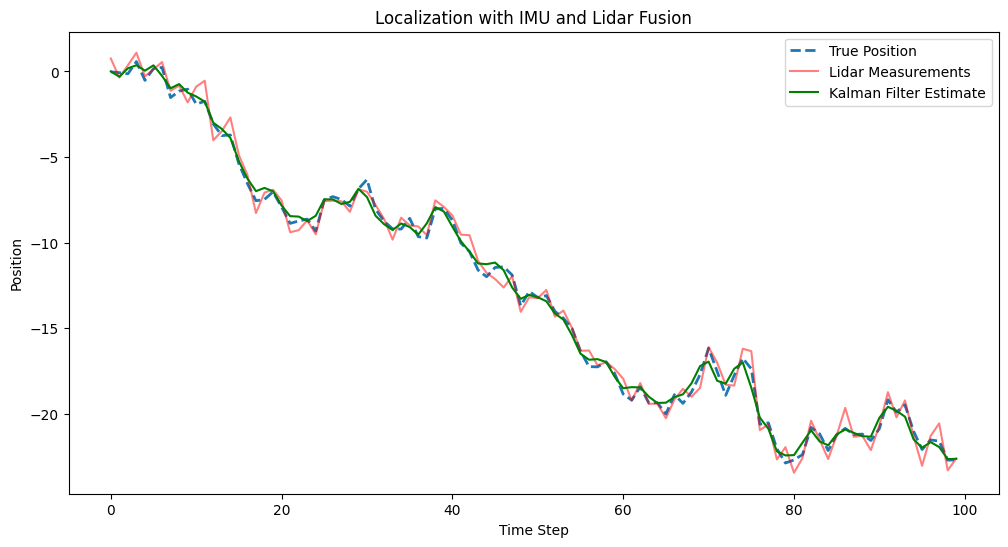

In [ ]:
# Simulasi data sensor
dt = 0.1  # Interval waktu (detik)
steps = 100  # Jumlah langkah simulasi

# Data ground truth (posisi dan orientasi sebenarnya)
true_positions = np.cumsum(np.random.randn(steps))  # Posisi sejati
true_orientations = np.cumsum(np.random.randn(steps) * 0.05)  # Orientasi sejati (rad)

# Simulasi IMU (gyroscope & accelerometer)
imu_acc_noise = 0.2  # Noise akselerasi
imu_gyro_noise = 0.01  # Noise gyroscope
imu_acc = np.gradient(true_positions, dt) + np.random.randn(steps) * imu_acc_noise
imu_gyro = np.gradient(true_orientations, dt) + np.random.randn(steps) * imu_gyro_noise

# Simulasi lidar untuk pengukuran posisi
lidar_noise = 0.5
lidar_positions = true_positions + np.random.randn(steps) * lidar_noise

# Kalman Filter untuk data fusion (menggabungkan IMU dan lidar)
kf_positions = np.zeros(steps)
kf_orientations = np.zeros(steps)

kf_position_uncertainty = 1.0
kf_orientation_uncertainty = 0.1
imu_process_noise = 0.01
lidar_measurement_noise = lidar_noise**2

for t in range(1, steps):
    # Predict step (integrasi IMU)
    kf_positions[t] = kf_positions[t-1] + imu_acc[t] * dt
    kf_orientations[t] = kf_orientations[t-1] + imu_gyro[t] * dt
    kf_position_uncertainty += imu_process_noise

    # Update step (sensor lidar)
    kalman_gain = kf_position_uncertainty / (kf_position_uncertainty + lidar_measurement_noise)
    kf_positions[t] += kalman_gain * (lidar_positions[t] - kf_positions[t])
    kf_position_uncertainty *= (1 - kalman_gain)

# Visualisasi hasil
plt.figure(figsize=(12, 6))
plt.plot(true_positions, label="True Position", linestyle='--', linewidth=2)
plt.plot(lidar_positions, label="Lidar Measurements", alpha=0.5, color='red')
plt.plot(kf_positions, label="Kalman Filter Estimate", color='green')
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.legend()
plt.title("Localization with IMU and Lidar Fusion")
plt.show()


#Implementasi simulasi Extended Kalman Filter (EKF) untuk Navigation

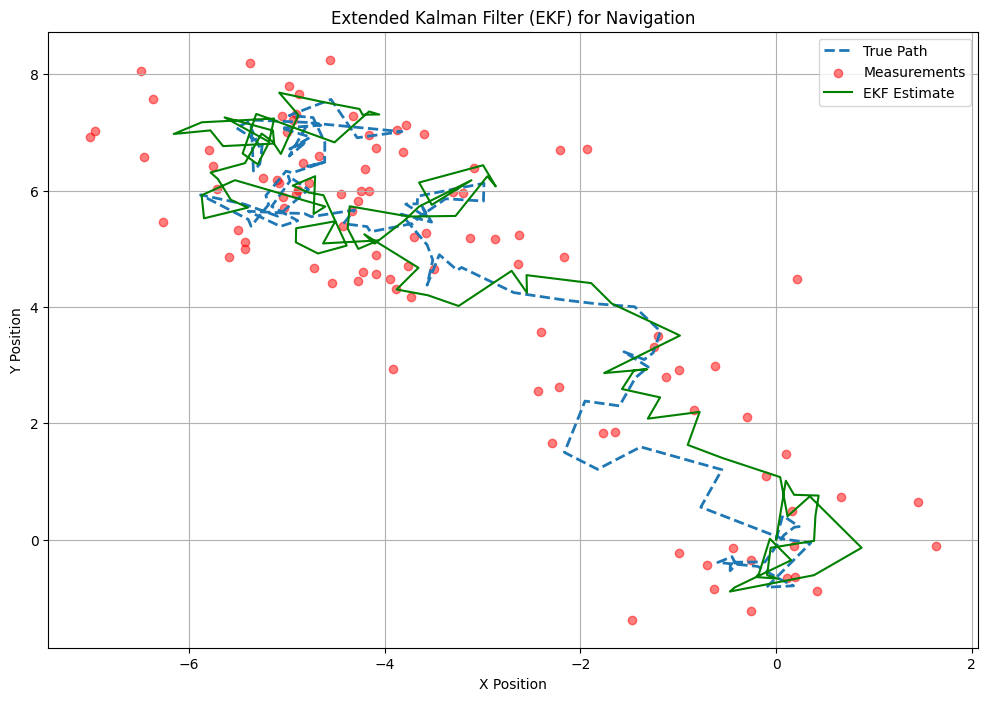

In [ ]:
# Cell: Simulasi Extended Kalman Filter (EKF) untuk Navigasi

# Fungsi non-linear untuk model gerakan dan pengukuran
def motion_model(state, control_input, dt):
    """Model gerakan non-linear (posisi & orientasi)."""
    x, y, theta = state  # Posisi (x, y) dan orientasi (theta)
    v, w = control_input  # Kecepatan linear dan angular
    new_theta = theta + w * dt
    new_x = x + v * np.cos(new_theta) * dt
    new_y = y + v * np.sin(new_theta) * dt
    return np.array([new_x, new_y, new_theta])

def measurement_model(state):
    """Model pengukuran (mengamati hanya posisi)."""
    x, y, _ = state
    return np.array([x, y])

# Jacobian matriks untuk linearisasi
def jacobian_motion(state, control_input, dt):
    """Jacobian dari motion model (partikel terhadap state)."""
    _, _, theta = state
    v, w = control_input
    jF = np.array([
        [1, 0, -v * np.sin(theta) * dt],
        [0, 1, v * np.cos(theta) * dt],
        [0, 0, 1]
    ])
    return jF

def jacobian_measurement():
    """Jacobian dari measurement model (observasi terhadap state)."""
    return np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])

# Parameter simulasi
dt = 0.1  # Interval waktu
steps = 100
control_inputs = np.array([np.ones(steps) * 1, np.ones(steps) * 0.1]).T  # Input gerakan

# Noise
motion_noise_cov = np.diag([0.1, 0.1, 0.05])  # Noise pada gerakan
measurement_noise_cov = np.diag([0.5, 0.5])  # Noise pada pengukuran

# Inisialisasi EKF
state = np.array([0, 0, 0])  # Posisi awal (x, y, theta)
state_cov = np.eye(3)  # Ketidakpastian awal

# Simulasi ground truth dan pengukuran
true_states = [state]
measurements = []
estimated_states = [state]

for t in range(steps):
    # Simulasi ground truth
    true_state = motion_model(true_states[-1], control_inputs[t], dt)
    true_state += np.random.multivariate_normal(np.zeros(3), motion_noise_cov)
    true_states.append(true_state)

    # Simulasi pengukuran
    measurement = measurement_model(true_state)
    measurement += np.random.multivariate_normal(np.zeros(2), measurement_noise_cov)
    measurements.append(measurement)

    # EKF Predict
    predicted_state = motion_model(state, control_inputs[t], dt)
    jF = jacobian_motion(state, control_inputs[t], dt)
    predicted_cov = jF @ state_cov @ jF.T + motion_noise_cov

    # EKF Update
    z = measurement  # Observasi
    z_hat = measurement_model(predicted_state)  # Prediksi observasi
    jH = jacobian_measurement()
    S = jH @ predicted_cov @ jH.T + measurement_noise_cov
    K = predicted_cov @ jH.T @ np.linalg.inv(S)  # Kalman gain
    state = predicted_state + K @ (z - z_hat)  # Pembaruan state
    state_cov = (np.eye(len(K)) - K @ jH) @ predicted_cov  # Pembaruan kovarian

    estimated_states.append(state)

# Konversi ke numpy array
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

# Visualisasi hasil
plt.figure(figsize=(12, 8))
plt.plot(true_states[:, 0], true_states[:, 1], label="True Path", linestyle='--', linewidth=2)
plt.scatter(measurements[:, 0], measurements[:, 1], label="Measurements", color='red', alpha=0.5)
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label="EKF Estimate", color='green')
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Extended Kalman Filter (EKF) for Navigation")
plt.grid()
plt.show()

#Implementasi Particle Filter untuk Navigasi

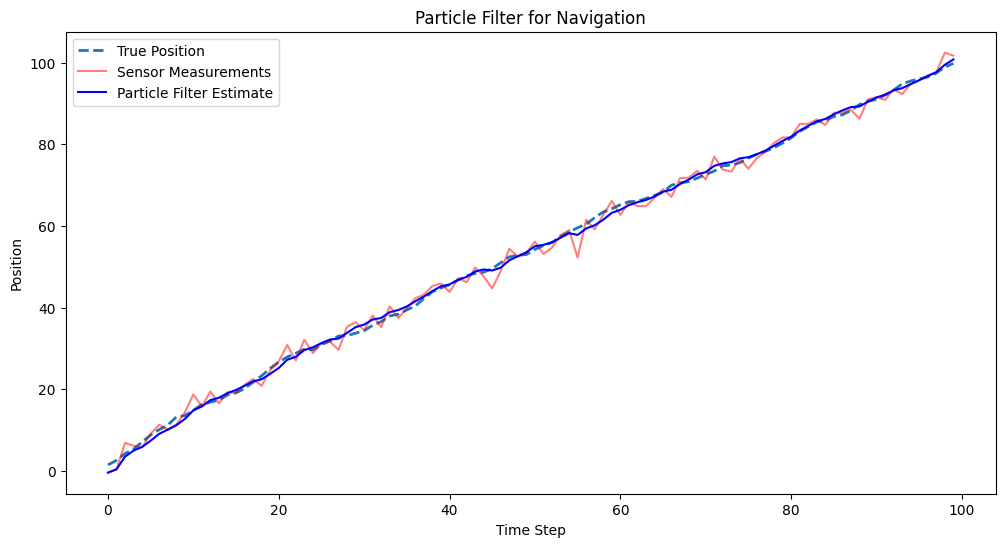

In [ ]:
# Parameter simulasi navigasi
num_particles = 1000  # Jumlah partikel
steps = 100  # Jumlah langkah simulasi

def simulate_robot_motion(position, velocity, noise_std):
    """Simulasi pergerakan robot dengan noise."""
    return position + velocity + np.random.randn() * noise_std

def simulate_sensor_measurement(position, noise_std):
    """Simulasi pengukuran sensor dengan noise."""
    return position + np.random.randn() * noise_std

# Inisialisasi posisi sejati, kecepatan, dan partikel
true_position = 0
true_velocity = 1  # Robot bergerak konstan
motion_noise = 0.5  # Noise pada gerakan
sensor_noise = 2.0  # Noise pada pengukuran sensor

particles = np.random.uniform(-20, 20, num_particles)
weights = np.ones(num_particles) / num_particles

# Penyimpanan hasil estimasi
true_positions = []
particle_estimations = []
sensor_measurements = []

for t in range(steps):
    # Pergerakan robot sejati
    true_position = simulate_robot_motion(true_position, true_velocity, motion_noise)
    true_positions.append(true_position)

    # Pengukuran sensor
    measurement = simulate_sensor_measurement(true_position, sensor_noise)
    sensor_measurements.append(measurement)

    # Particle filter predict step: update posisi partikel
    particles += true_velocity + np.random.randn(num_particles) * motion_noise

    # Update step: hitung bobot partikel berdasarkan sensor
    weights *= np.exp(-0.5 * ((measurement - particles) / sensor_noise)**2)
    weights += 1.e-300  # Hindari pembagian dengan nol
    weights /= np.sum(weights)  # Normalisasi bobot

    # Resampling step: pilih partikel berdasarkan bobot
    indices = np.random.choice(num_particles, size=num_particles, p=weights)
    particles = particles[indices]
    weights = np.ones(num_particles) / num_particles

    # Estimasi posisi berdasarkan rata-rata partikel
    estimated_position = np.mean(particles)
    particle_estimations.append(estimated_position)

# Visualisasi hasil
plt.figure(figsize=(12, 6))
plt.plot(true_positions, label="True Position", linestyle='--', linewidth=2)
plt.plot(sensor_measurements, label="Sensor Measurements", alpha=0.5, color='red')
plt.plot(particle_estimations, label="Particle Filter Estimate", color='blue')
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.legend()
plt.title("Particle Filter for Navigation")
plt.show()